# What is in this notebook?

This notebook contains my analysis for finding the grid transparency of PUMA in Argon.

# First Step: Getting all Waveforms

**Pressure:** 1000.1 mBAR

**Testing with:** VG16VA56

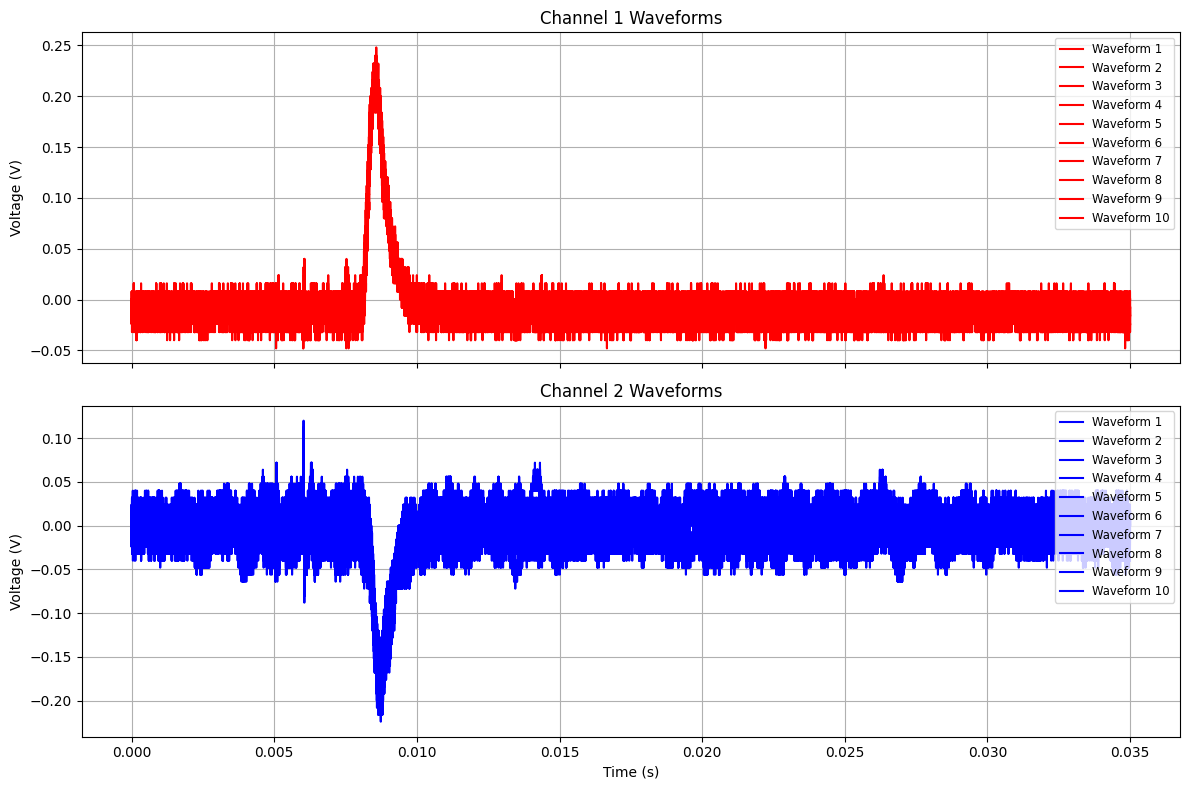

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = np.loadtxt("VG16VA56.txt")

num_samples, total_cols = data.shape
assert total_cols == 20, "Expecting 20 columns: 10 waveforms for each of 2 channels"

# Split columns into two groups of 10 each
ch1_waveforms = data[:, 0:10]   # first 10 columns: Channel 1
ch2_waveforms = data[:, 10:20]  # next 10 columns: Channel 2

# Time axis setup
waveform_duration = (1e-6) * 5000
dt = 1e-6 #waveform_duration / num_samples
time = np.arange(num_samples) * dt

# Plot waveforms for Channel 1 and Channel 2 separately
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

for i in range(10):
    axs[0].plot(time, ch1_waveforms[:, i], label=f"Waveform {i+1}", color = "red")
axs[0].set_title("Channel 1 Waveforms")
axs[0].set_ylabel("Voltage (V)")
axs[0].legend(loc='upper right', fontsize='small')
axs[0].grid(True)

for i in range(10):
    axs[1].plot(time, ch2_waveforms[:, i], label=f"Waveform {i+1}", color = "blue")
axs[1].set_title("Channel 2 Waveforms")
axs[1].set_ylabel("Voltage (V)")
axs[1].set_xlabel("Time (s)")
axs[1].legend(loc='upper right', fontsize='small')
axs[1].grid(True)

plt.tight_layout()
plt.show()


# Second Step: Subtract Pedestal (Baseline) and Avg

We subtract the average amplitude of the signal before the pulse. Essentially, we get rid of any vertical offset that the signal had so that it is now centered around zero. Afterwards, we take the average of the waveform.

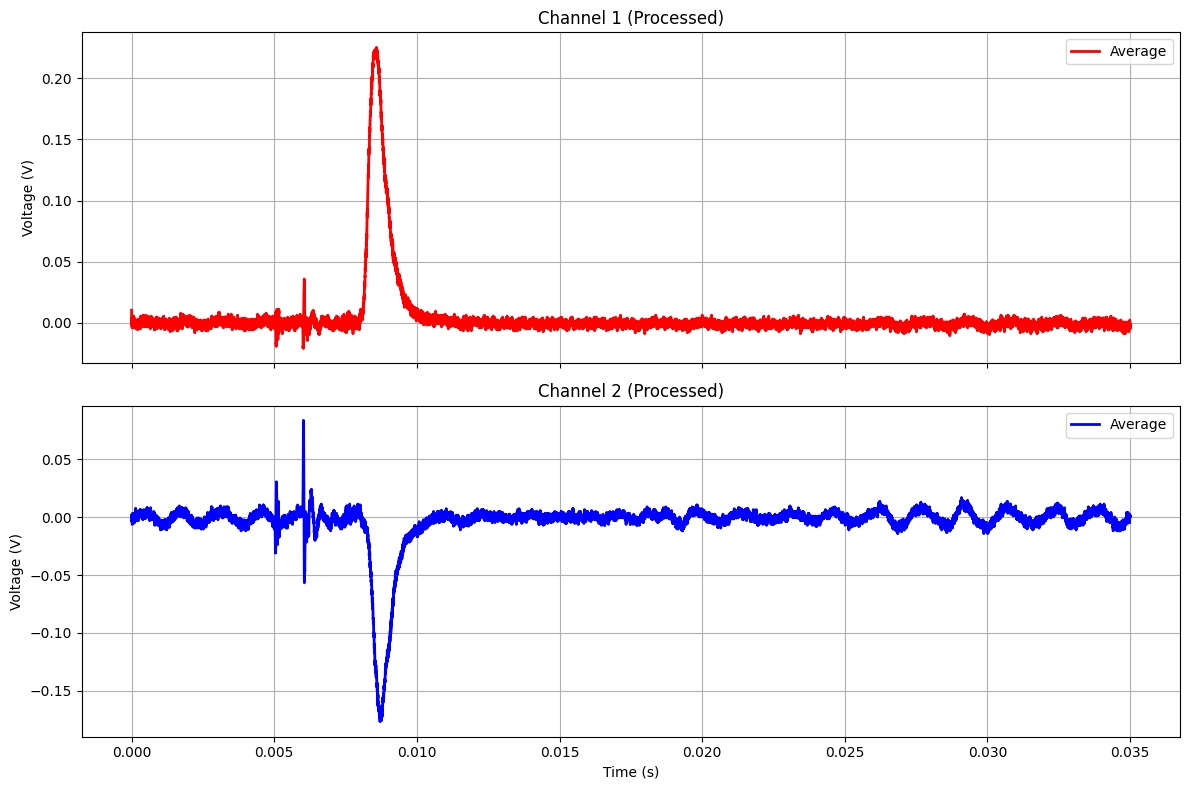

In [2]:
baseline_region = slice(0, int(0.1 * num_samples))  # first 10% of samples

# Subtract pedestal for Channel 1
ch1_baselines = np.mean(ch1_waveforms[baseline_region, :], axis=0)  # shape: (10,)
ch1_waveforms_corrected = ch1_waveforms - ch1_baselines  # broadcasting

# Subtract pedestal for Channel 2
ch2_baselines = np.mean(ch2_waveforms[baseline_region, :], axis=0)
ch2_waveforms_corrected = ch2_waveforms - ch2_baselines

# Recompute averages after pedestal subtraction
ch1_avg = np.mean(ch1_waveforms_corrected, axis=1)
ch2_avg = np.mean(ch2_waveforms_corrected, axis=1)

# Plot again
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].plot(time, ch1_avg, color='red', linewidth=2, label='Average')
axs[0].set_title("Channel 1 (Processed)")
axs[0].set_ylabel("Voltage (V)")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(time, ch2_avg, color='blue', linewidth=2, label='Average')
axs[1].set_title("Channel 2 (Processed)")
axs[1].set_ylabel("Voltage (V)")
axs[1].set_xlabel("Time (s)")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Third Step: Fitting Data and Integrating

In [3]:
# Defining fit functions

from scipy.optimize import curve_fit
from scipy.special import erfc
from scipy import integrate
import warnings
warnings.filterwarnings('ignore')

def crystal_ball(x, alpha, n, x_bar, sigma, N):
    """
    Crystal Ball function (reflective version)
    
    Parameters:
    alpha: tail parameter (controls where the tail starts)
    n: tail slope parameter
    x_bar: mean
    sigma: width parameter
    N: normalization constant
    """
    t = (x - x_bar) / sigma
    
    # For reflective crystal ball, we flip the condition
    # Standard crystal ball has tail on left side (t < -alpha)
    # Reflective version has tail on right side (t > alpha)
    
    result = np.zeros_like(x)
    
    # Core region (Gaussian part)
    core_mask = t <= alpha
    result[core_mask] = N * np.exp(-0.5 * t[core_mask]**2)
    
    # Tail region (power law)
    tail_mask = t > alpha
    if np.any(tail_mask):
        A = (n / alpha)**n * np.exp(-0.5 * alpha**2)
        B = n / alpha - alpha
        result[tail_mask] = N * A * (B + t[tail_mask])**(-n)
    
    return result

def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0)**2 / (2 * sigma**2))

def integrate_crystal_ball(popt, time_range, method='quad'):
    """
    Integrate Crystal Ball function over a time range
    
    Parameters:
    -----------
    popt : tuple
        Fit parameters (N, mu, sigma, alpha, n)
    time_range : tuple
        (t_min, t_max) integration bounds
    method : str
        Integration method ('quad', 'trapz', 'simpson')
    
    Returns:
    --------
    float
        Integral value
    """
    t_min, t_max = time_range
    
    if method == 'quad':
        # Adaptive quadrature (most accurate for smooth functions)
        result, error = integrate.quad(
            lambda t: crystal_ball(t, *popt), 
            t_min, t_max
        )
        return result, error
    
    elif method == 'trapz':
        # Trapezoidal rule (good for tabulated data)
        t_points = np.linspace(t_min, t_max, 1000)
        y_values = crystal_ball(t_points, *popt)
        result = integrate.trapz(y_values, t_points)
        return result
    
    elif method == 'simpson':
        # Simpson's rule (good balance of accuracy and speed)
        t_points = np.linspace(t_min, t_max, 1001)  # Odd number for Simpson
        y_values = crystal_ball(t_points, *popt)
        result = integrate.simpson(y_values, t_points)
        return result
    
    else:
        raise ValueError("Method must be 'quad', 'trapz', or 'simpson'")

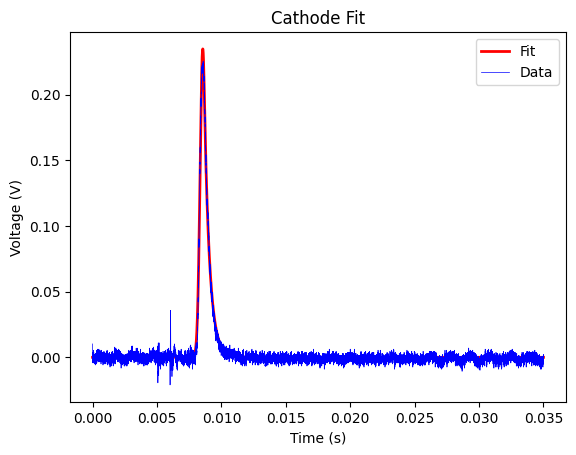

Area = 0.00016925972117161535, Error = 8.917892762845634e-09


In [4]:
# Fit on channel 1

# Initial guesses
x_bar_guess = time[np.argmax(ch1_avg)]
sigma_guess = (time[-1] - time[0]) / 10
N_guess = np.max(ch1_avg)

p0 = [1.5, 3.0, x_bar_guess, sigma_guess, N_guess]  # [alpha, n, x̄, sigma, N]

popt, pcov = curve_fit(crystal_ball, time, ch1_avg, p0=p0)
plt.plot(time, crystal_ball(time, *popt), c="red", linewidth = 2, label="Fit")
plt.plot(time, ch1_avg, linewidth=0.5, c="blue", label = "Data")
plt.title("Cathode Fit")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.legend()
#plt.xlim(0.005, 0.015)
plt.show()

time_range = (time[0],time[-1])

cathode_area, error = integrate_crystal_ball(popt, time_range, 'quad')

print(f"Area = {cathode_area}, Error = {error}")

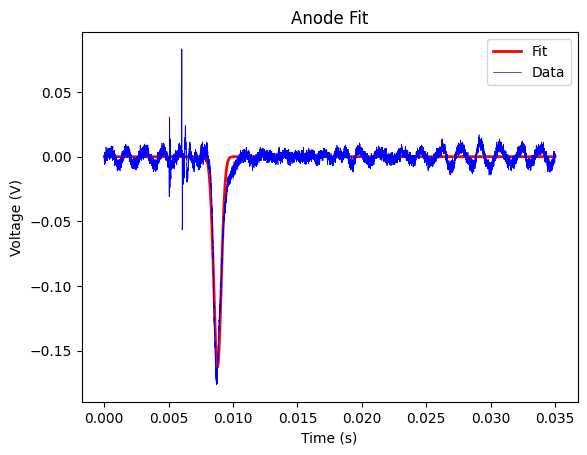

Area = -0.00011938534505442332, Error = 4.6325239013028273e-10


In [5]:
# Fit on channel 2

# Initial guesses
x_bar_guess = time[np.argmax(ch2_avg)]
sigma_guess = (time[-1] - time[0]) / 10
N_guess = np.max(ch2_avg)

p0 = [1.5, 3.0, x_bar_guess, sigma_guess, N_guess]  # [alpha, n, x̄, sigma, N]

popt, pcov = curve_fit(crystal_ball, time, ch2_avg, p0=p0)
plt.plot(time, crystal_ball(time, *popt), c="red", linewidth = 2, label="Fit")
plt.plot(time, ch2_avg, linewidth=0.5, c="blue", label = "Data")
plt.title("Anode Fit")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.legend()
#plt.xlim(0.005, 0.015)
plt.show()

time_range = (time[0],time[-1])

anode_area, error = integrate_crystal_ball(popt, time_range, 'quad')

print(f"Area = {anode_area}, Error = {error}")

# Fourth Step: Finding Charge

Now that we have the integral of both fits, we can find the charge at the anode and cathode using the transimpedance:

$$Q = \text{integral}\cdot Z_{T}$$

In [6]:
Z_A = 207 # kOhm
Z_C = 213 # kOhm

Q_A = Z_A * anode_area
Q_C = Z_C * cathode_area

grid_transparency = np.abs(Q_A/Q_C)

print(f"The grid transparency is = {grid_transparency}")

The grid transparency is = 0.6854695067733478
